In [1]:
# First let's load the file with all the flights in the US for the 12 months up to September 2024.

import pandas as pd

# Specify the file path
file_path = "./Flight_data_Sep2024_DoT.csv"

# Load the file into a Pandas DataFrame
flight_data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(flight_data.head())

# Display the column names
print("Column names:", flight_data.columns.tolist())


   Year  Month Origin_Airport  Origin_Airport_UC  Origin_Airport_WAC  \
0  2024      9            01A              30001                   1   
1  2024      8            01A              30001                   1   
2  2024      7            05A              30005                   1   
3  2024      8            06A              30006                   1   
4  2024      8            06A              30006                   1   

  Origin_Airport_City Destination_Airport  Destination_Airport_UC  \
0    Afognak Lake, AK                 A43                   30056   
1    Afognak Lake, AK                 A43                   30056   
2    Little Squaw, AK                 FAI                   31517   
3        Kizhuyak, AK                 A43                   30056   
4        Kizhuyak, AK                 A43                   30056   

   Destination_Airport_WAC Destination_Airport_City  ... Departures_Performed  \
0                        1        Kodiak Island, AK  ...               

In [2]:
# We want to filter only flights with F on the Service_Class column that have at least 12 scheduled flights on the year, 

# Number of rows before filtering
rows_before = len(flight_data)

# Filter for scheduled flight data with Service_Class = 'F' and Departures_Planned > 12
scheduled_flight_data = flight_data[
    (flight_data['Service_Class'] == 'F') & (flight_data['Departures_Planned'] > 12)
]

# Number of rows after filtering
rows_after = len(scheduled_flight_data)

# Print the results
print(f"Number of rows before filtering: {rows_before}")
print(f"Number of rows after filtering: {rows_after}")


Number of rows before filtering: 433430
Number of rows after filtering: 159581


In [3]:
# Group the data by origin and destination airport codes 
grouped_data = scheduled_flight_data.groupby(
    ['Origin_Airport', 'Destination_Airport']
).agg(
    Total_Available_seats=('Available_seats', 'sum'),
    Total_Passengers_transported=('Passengers_transported', 'sum')
).reset_index()

# Save the grouped dataset to a new DataFrame
flight_data = grouped_data[['Origin_Airport', 'Destination_Airport', 
                                 'Total_Available_seats', 'Total_Passengers_transported']]

# Display the first few rows of the new dataset
print(flight_data.head())

# Optionally save the new dataset to a CSV file
flight_data.to_csv("./Consolidated_Flight_Data.csv", index=False)

print(f"Total Available Seats: {flight_data['Total_Available_seats'].sum()}")
print(f"Total Passengers Transported: {flight_data['Total_Passengers_transported'].sum()}")
print(f"Load factor: {flight_data['Total_Passengers_transported'].sum()/flight_data['Total_Available_seats'].sum()}")


  Origin_Airport Destination_Airport  Total_Available_seats  \
0            2WA                 2WA                   1595   
1            2WA                 FBS                    920   
2            2WA                 KEH                    560   
3            7AK                 DUT                   3171   
4            ABE                 ATL                  72255   

   Total_Passengers_transported  
0                           974  
1                           334  
2                            65  
3                           780  
4                         63643  
Total Available Seats: 945301832
Total Passengers Transported: 772665261
Load factor: 0.817374128393734


In [4]:
# Let's generate the data in a format where we can build a graph. The nodes are the airpots and the weights are the available seats and the transported passengers. 

import pandas as pd
import networkx as nx
import pickle

# Load the dataset
file_path = './Consolidated_Flight_Data.csv'
flight_data = pd.read_csv(file_path)

# Initialize a directed graph
G = nx.DiGraph()

# Add edges with weights to the graph
for _, row in flight_data.iterrows():
    origin = row['Origin_Airport']
    destination = row['Destination_Airport']
    available_seats = row['Total_Available_seats']
    passengers = row['Total_Passengers_transported']
    
    # Add the edge with weights
    G.add_edge(
        origin, 
        destination, 
        available_seats=available_seats, 
        passengers=passengers
    )

# Save the graph using pickle
output_file = "./flight_graph.pkl"
with open(output_file, 'wb') as f:
    pickle.dump(G, f)
print(f"Graph saved to {output_file}")

# Reload the graph later if needed
# with open(output_file, 'rb') as f:
#     G = pickle.load(f)


Graph saved to ./flight_graph.pkl


In [5]:
# Let's check the structure of the graph and subgraphs. 

import networkx as nx
from collections import Counter

# Calculate the weakly connected components (subgraphs)
subgraph_sizes = [len(component) for component in nx.weakly_connected_components(G)]

# Count the subgraphs by their size
subgraph_size_counts = Counter(subgraph_sizes)

# Sort the counts by the number of nodes
sorted_subgraph_sizes = sorted(subgraph_size_counts.items(), key=lambda x: x[0])

# Display the results
print("Subgraph Sizes (Ordered by Number of Nodes):")
for size, count in sorted_subgraph_sizes:
    print(f"{count} subgraphs with {size} nodes")


Subgraph Sizes (Ordered by Number of Nodes):
6 subgraphs with 2 nodes
1 subgraphs with 3 nodes
2 subgraphs with 5 nodes
1 subgraphs with 9 nodes
1 subgraphs with 551 nodes


In [14]:
# Clean up subgraphs that are not relevant. 

import networkx as nx
import pickle

# Load the graph from a file
file_path = 'flight_graph.pkl'  # Update this with the path to your graph file
with open(file_path, 'rb') as f:
    G = pickle.load(f)

# Identify subgraphs with fewer than 10 nodes and remove them
subgraphs_to_remove = [component for component in nx.weakly_connected_components(G) if len(component) < 10]
nodes_to_remove = set(node for component in subgraphs_to_remove for node in component)
G_clean = G.copy()
G_clean.remove_nodes_from(nodes_to_remove)

# Save the cleaned graph to a new file
cleaned_file_path = 'flight_graph_clean.pkl'  # Update this with the desired output file name
with open(cleaned_file_path, 'wb') as f:
    pickle.dump(G_clean, f)

G = G_clean

print(f"Cleaned graph saved to {cleaned_file_path}")


Cleaned graph saved to flight_graph_clean.pkl


In [15]:
# Let's check if there are sub-graphs
import networkx as nx

# Check if the graph is strongly connected
is_strongly_connected = nx.is_strongly_connected(G)

# Check if the graph is weakly connected
is_weakly_connected = nx.is_weakly_connected(G)

# Count the number of strongly connected components (subgraphs)
num_strongly_connected_components = nx.number_strongly_connected_components(G)

# Count the number of weakly connected components (subgraphs)
num_weakly_connected_components = nx.number_weakly_connected_components(G)

# Print the results
print("Graph Connectivity and Subgraph Analysis:")
print(f"Is Strongly Connected: {'Yes' if is_strongly_connected else 'No'}")
print(f"Is Weakly Connected: {'Yes' if is_weakly_connected else 'No'}")
print(f"Number of Strongly Connected Components: {num_strongly_connected_components}")
print(f"Number of Weakly Connected Components: {num_weakly_connected_components}")



Graph Connectivity and Subgraph Analysis:
Is Strongly Connected: No
Is Weakly Connected: Yes
Number of Strongly Connected Components: 11
Number of Weakly Connected Components: 1


Number of nodes (airports): 551
Number of edges (flights): 6545

Top 5 airports by in-degree (most incoming destinations):
DFW: 188 destinations
DEN: 182 destinations
ORD: 167 destinations
ATL: 157 destinations
CLT: 138 destinations

Top 5 airports by out-degree (most outgoing destinations):
DFW: 188 destinations
DEN: 181 destinations
ORD: 168 destinations
ATL: 157 destinations
CLT: 139 destinations


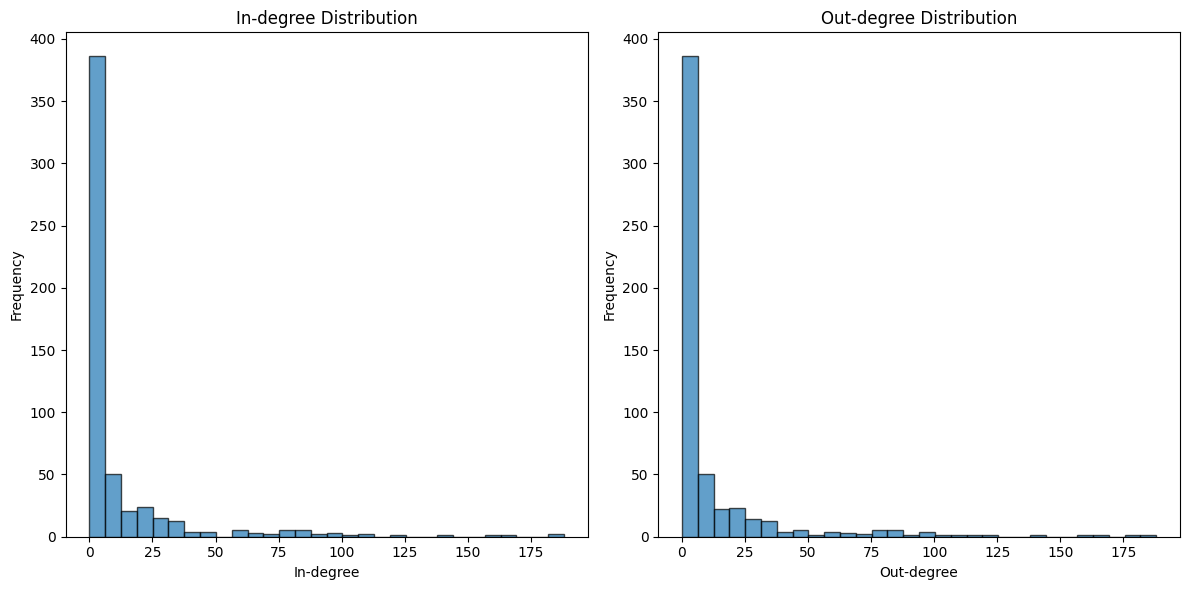

In [16]:
# Let's do a basic analysis of the graph.

import networkx as nx
import matplotlib.pyplot as plt


output_file = "./flight_graph_clean.pkl"

with open(output_file, 'rb') as f:
     G = pickle.load(f)



# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes (airports): {num_nodes}")
print(f"Number of edges (flights): {num_edges}")

# Compute in-degree and out-degree distributions
in_degrees = dict(G.in_degree())  # Number of incoming edges for each node
out_degrees = dict(G.out_degree())  # Number of outgoing edges for each node

# Top 5 airports with the highest in-degree
top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by in-degree (most incoming destinations):")
for airport, degree in top_in_degree:
    print(f"{airport}: {degree} destinations")

# Top 5 airports with the highest out-degree
top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by out-degree (most outgoing destinations):")
for airport, degree in top_out_degree:
    print(f"{airport}: {degree} destinations")

# Plot degree distributions
plt.figure(figsize=(12, 6))

# In-degree distribution
plt.subplot(1, 2, 1)
plt.hist(in_degrees.values(), bins=30, edgecolor='black', alpha=0.7)
plt.title("In-degree Distribution")
plt.xlabel("In-degree")
plt.ylabel("Frequency")

# Out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(out_degrees.values(), bins=30, edgecolor='black', alpha=0.7)
plt.title("Out-degree Distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [17]:
# Calculate centrality measures. 

import networkx as nx

# 1. Degree Centrality
degree_centrality = nx.degree_centrality(G)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by Degree Centrality (most connections):")
for airport, centrality in top_degree_centrality:
    print(f"{airport}: {centrality:.4f}")

# 2. Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by Betweenness Centrality (critical for connectivity):")
for airport, centrality in top_betweenness_centrality:
    print(f"{airport}: {centrality:.4f}")

# 3. Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by Closeness Centrality (reach others quickly):")
for airport, centrality in top_closeness_centrality:
    print(f"{airport}: {centrality:.4f}")

# 4. Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
top_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by Eigenvector Centrality (connected to important airports):")
for airport, centrality in top_eigenvector_centrality:
    print(f"{airport}: {centrality:.4f}")



Top 5 airports by Degree Centrality (most connections):
DFW: 0.6836
DEN: 0.6600
ORD: 0.6091
ATL: 0.5709
CLT: 0.5036

Top 5 airports by Betweenness Centrality (critical for connectivity):
ANC: 0.2975
DEN: 0.1581
DFW: 0.1389
BET: 0.1219
ORD: 0.1210

Top 5 airports by Closeness Centrality (reach others quickly):
DEN: 0.5237
DFW: 0.5157
ORD: 0.5152
ATL: 0.4982
MSP: 0.4968

Top 5 airports by Eigenvector Centrality (connected to important airports):
DFW: 0.1890
ATL: 0.1863
DEN: 0.1861
ORD: 0.1804
CLT: 0.1657


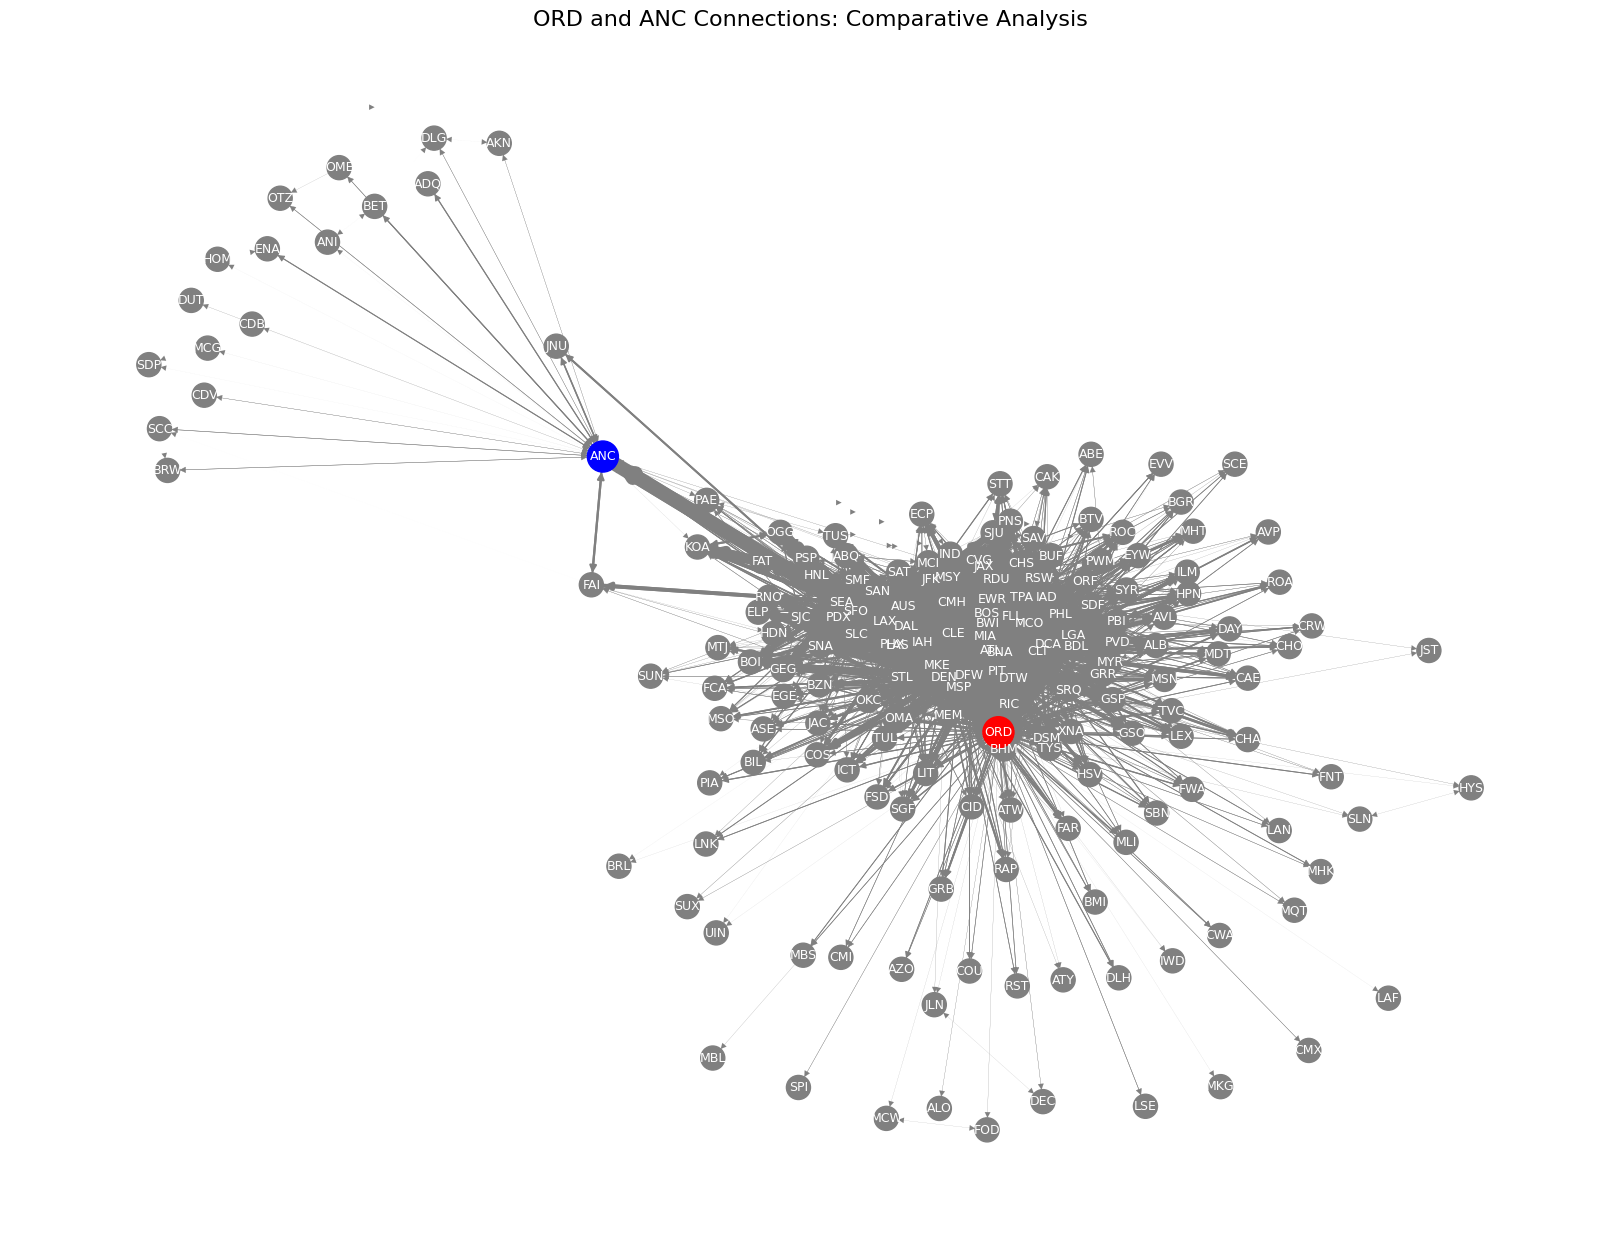

Comparison Between ANC (Anchorage) and ORD (Chicago O'Hare):

ANC (Anchorage):
  In-Degree: 37
  Out-Degree: 37
  Total Passengers (Outgoing): 2287880
  Total Available Seats (Outgoing): 3011163
  Betweenness Centrality: 0.29747520609962264

ORD (Chicago O'Hare):
  In-Degree: 167
  Out-Degree: 168
  Total Passengers (Outgoing): 28193693
  Total Available Seats (Outgoing): 33677750
  Betweenness Centrality: 0.12102699846678151


In [18]:
# ANC - Anchorage in Alaska shows a very high Betweeness centrality number and it is an outliar if we consider other centrality measures. 
# Let's check the results against ORD (Chicago)

import networkx as nx
import matplotlib.pyplot as plt

# Function to analyze a specific airport
def analyze_airport(graph, airport):
    # Degree Analysis
    in_degree = graph.in_degree(airport)
    out_degree = graph.out_degree(airport)
    
    # Total passengers and available seats
    edges = graph.edges(airport, data=True)  # Outgoing flights
    total_passengers = sum(edge_data['passengers'] for _, _, edge_data in edges)
    total_available_seats = sum(edge_data['available_seats'] for _, _, edge_data in edges)
    
    # Betweenness Centrality
    betweenness = nx.betweenness_centrality(graph).get(airport, 0)
    
    return {
        "In-Degree": in_degree,
        "Out-Degree": out_degree,
        "Total Passengers (Outgoing)": total_passengers,
        "Total Available Seats (Outgoing)": total_available_seats,
        "Betweenness Centrality": betweenness,
    }

# Analyze ANC and ORD
anc_metrics = analyze_airport(G, 'ANC')
ord_metrics = analyze_airport(G, 'ORD')

# Comparison
comparison = {
    "ANC (Anchorage)": anc_metrics,
    "ORD (Chicago O'Hare)": ord_metrics,
}

# Visualization: Subgraph for ANC and ORD
ord_anc_nodes = ['ORD', 'ANC'] + list(G.successors('ORD')) + list(G.predecessors('ORD')) \
    + list(G.successors('ANC')) + list(G.predecessors('ANC'))
ord_anc_subgraph = G.subgraph(ord_anc_nodes)

# Node sizes based on importance
node_sizes = [500 if node in ['ORD', 'ANC'] else 300 for node in ord_anc_subgraph.nodes()]

# Edge widths based on passenger volume
edge_widths = [
    edge_data['passengers'] / 1e5 for _, _, edge_data in ord_anc_subgraph.edges(data=True)
]

# Node colors
node_colors = ['red' if node == 'ORD' else 'blue' if node == 'ANC' else 'gray' for node in ord_anc_subgraph.nodes()]

# Plot the subgraph for ORD and ANC
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(ord_anc_subgraph, seed=42)
nx.draw(
    ord_anc_subgraph,
    pos,
    with_labels=True,
    node_size=node_sizes,
    font_size=9,
    font_color="white",
    edge_color="gray",
    width=edge_widths,
    node_color=node_colors,
)

# Add title
plt.title("ORD and ANC Connections: Comparative Analysis", fontsize=16)
plt.show()

# Print comparison
print("Comparison Between ANC (Anchorage) and ORD (Chicago O'Hare):")
for airport, metrics in comparison.items():
    print(f"\n{airport}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


In [19]:
import networkx as nx

# Check if the graph is directed
is_directed = isinstance(G, nx.DiGraph)

# Output the result
if is_directed:
    print("The graph is directed.")
else:
    print("The graph is undirected.")


The graph is directed.


In [20]:
import networkx as nx
from collections import Counter

# Calculate the weakly connected components (subgraphs) for the directed graph
subgraph_sizes = [len(component) for component in nx.weakly_connected_components(G)]

# Count the subgraphs by their size
subgraph_size_counts = Counter(subgraph_sizes)

# Sort the counts by the number of nodes
sorted_subgraph_sizes = sorted(subgraph_size_counts.items(), key=lambda x: x[0])

# Display the results
print("Subgraph Sizes (Ordered by Number of Nodes):")
for size, count in sorted_subgraph_sizes:
    print(f"{count} subgraphs with {size} nodes")


Subgraph Sizes (Ordered by Number of Nodes):
1 subgraphs with 551 nodes


In [21]:
import networkx as nx

# Check if the graph is strongly connected
is_strongly_connected = nx.is_strongly_connected(G)

# Check if the graph is weakly connected
is_weakly_connected = nx.is_weakly_connected(G)

# Output the results
print(f"Is the graph strongly connected? {'Yes' if is_strongly_connected else 'No'}")
print(f"Is the graph weakly connected? {'Yes' if is_weakly_connected else 'No'}")


Is the graph strongly connected? No
Is the graph weakly connected? Yes


In [22]:
import networkx as nx

# Get the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(G), key=len)

# Find nodes that are not in the largest SCC
unconnected_nodes = set(G.nodes()) - largest_scc

# Display the results
print(f"Number of unconnected nodes: {len(unconnected_nodes)}")
print("Unconnected nodes:", unconnected_nodes)


Number of unconnected nodes: 10
Unconnected nodes: {'TEK', 'IGG', 'KCG', 'STG', 'NIB', 'NCN', 'WSN', 'MRI', 'ANV', 'KGX'}


In [23]:
import networkx as nx

# Identify nodes with less than 500 total passengers
nodes_to_remove = []
for node in G_clean.nodes():
    total_passengers = sum(
        data.get('passengers', 0)
        for _, _, data in G_clean.in_edges(node, data=True)
    ) + sum(
        data.get('passengers', 0)
        for _, _, data in G_clean.out_edges(node, data=True)
    )
    if total_passengers < 500:
        nodes_to_remove.append(node)

# Remove these nodes from the graph
G_filtered = G_clean.copy()
G_filtered.remove_nodes_from(nodes_to_remove)

# Save the filtered graph to a new file
filtered_file_path = './flight_graph_filtered.pkl'
with open(filtered_file_path, 'wb') as f:
    pickle.dump(G_filtered, f)

G = G_filtered

print(f"Filtered graph saved to {filtered_file_path}")


Filtered graph saved to ./flight_graph_filtered.pkl


In [24]:
import networkx as nx
import random
from concurrent.futures import ThreadPoolExecutor

# Function to compute connectivity details
def graph_connectivity_info(graph):
    is_connected = nx.is_strongly_connected(graph)
    num_subgraphs = nx.number_strongly_connected_components(graph)
    return is_connected, num_subgraphs

# Function to remove nodes based on strategy
def remove_nodes(graph, strategy, num_nodes):
    graph_copy = graph.copy()
    nodes = list(graph_copy.nodes())
    if strategy == "random":
        nodes_to_remove = random.sample(nodes, num_nodes)
    else:
        if strategy == "degree":
            centrality = nx.degree_centrality(graph_copy)
        elif strategy == "betweenness":
            centrality = nx.betweenness_centrality(graph_copy)
        elif strategy == "closeness":
            centrality = nx.closeness_centrality(graph_copy)
        nodes_to_remove = [
            node for node, _ in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:num_nodes]
        ]
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

# Task for concurrent execution
def analyze_removal(graph, strategy, num_nodes):
    modified_graph = remove_nodes(graph, strategy, num_nodes)
    is_connected, num_subgraphs = graph_connectivity_info(modified_graph)
    return strategy, num_nodes, is_connected, num_subgraphs

# Parameters
strategies = ["random", "degree", "betweenness", "closeness"]
node_removals = [1, 2, 3, 5, 10, 20, 30, 50]

# Execute using ThreadPoolExecutor
results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(analyze_removal, G, strategy, num)
        for strategy in strategies
        for num in node_removals
    ]
    for future in futures:
        results.append(future.result())

# Display results
for strategy, num_nodes, is_connected, num_subgraphs in results:
    print(f"Strategy: {strategy}, Nodes Removed: {num_nodes}, "
          f"Connected: {is_connected}, Subgraphs: {num_subgraphs}")


Strategy: random, Nodes Removed: 1, Connected: True, Subgraphs: 1
Strategy: random, Nodes Removed: 2, Connected: True, Subgraphs: 1
Strategy: random, Nodes Removed: 3, Connected: False, Subgraphs: 3
Strategy: random, Nodes Removed: 5, Connected: True, Subgraphs: 1
Strategy: random, Nodes Removed: 10, Connected: False, Subgraphs: 4
Strategy: random, Nodes Removed: 20, Connected: False, Subgraphs: 5
Strategy: random, Nodes Removed: 30, Connected: False, Subgraphs: 23
Strategy: random, Nodes Removed: 50, Connected: False, Subgraphs: 6
Strategy: degree, Nodes Removed: 1, Connected: False, Subgraphs: 18
Strategy: degree, Nodes Removed: 2, Connected: False, Subgraphs: 39
Strategy: degree, Nodes Removed: 3, Connected: False, Subgraphs: 53
Strategy: degree, Nodes Removed: 5, Connected: False, Subgraphs: 74
Strategy: degree, Nodes Removed: 10, Connected: False, Subgraphs: 111
Strategy: degree, Nodes Removed: 20, Connected: False, Subgraphs: 155
Strategy: degree, Nodes Removed: 30, Connected: Fa